# Thinkful Unit 1 Capstone
#### By Eve Ben Ezra
## Can we use data science to propose a way to reduce the amount of animals that are sent to a shelter? 

Using data from this kaggle set about an Austin animal shelter (https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes), I want to explore how many animals go to this shelter each month and year, why, and what their 'outcomes' are. 

It's well-known that animal shelters are often overcrowded. Due to overcrowding, each year many animals face euthanasia if they cannot be adopted out of a shelter. 

Reducing the number of animals that are sent to a shelter each year will result in more funds and space available for animals that do end up in shelters, hopefully leading to more positive outcomes and less euthanasia.

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re #regular expressions
import scipy.stats
import datetime as dt
%matplotlib inline

In [182]:
# Toggle code on or off

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [183]:
intakes_outcomes = pd.read_csv('aac_intakes_outcomes.csv')

intakes = pd.read_csv('aac_intakes.csv')

outcomes = pd.read_csv('aac_outcomes.csv')

merge = [intakes_outcomes, intakes, outcomes]

df = pd.concat(merge, sort=False)

In [314]:
intakes_outcomes.head()

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,outcome_date
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194,2017-12-07
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722,2014-12-20
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889,2014-03-08
3,10 years,A047759,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,...,2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139,2014-04-07
4,16 years,A134067,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,...,2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444,2013-11-16


In [185]:
df.shape

(240540, 46)

## Part 1: Exploring the Data


### What Kind of Animals Are Brought To The Shelter?

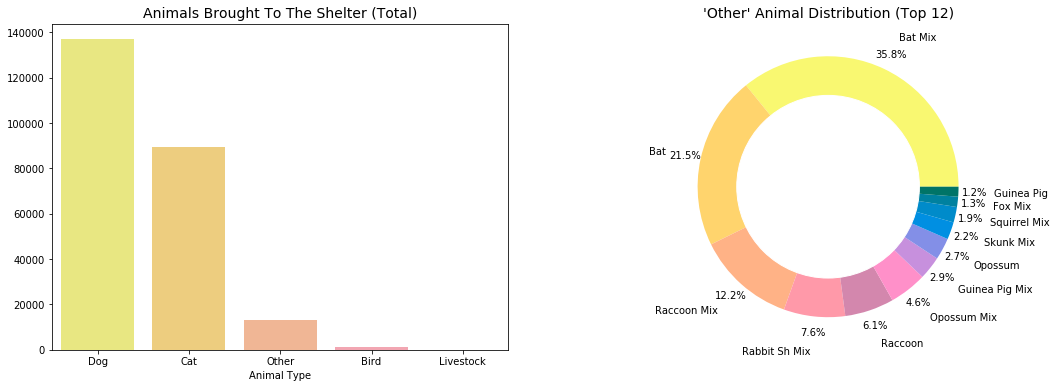

In [288]:
animal_counts = df['animal_type'].value_counts()

color_scheme = ['#F9F871','#FFD46D','#FFB286','#FF99A9','#D387AD','#FF90C9', 
                '#C790DD', '#838FE7', '#008FE2', '#008BCA', '#00819F', '#007467']

Other = df[df['animal_type']=='Other']
# Create the data for which kind of animals are included in the 'other' category
Other1 = Other.groupby(['breed'])[['count']].sum().reset_index().sort_values(by='count', ascending=False).head(12)
names1 = Other1['breed']
size_of_groups1 = Other1['count']

plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
sns.barplot(animal_counts.index, animal_counts.values, palette=color_scheme)
plt.title('Animals Brought To The Shelter (Total)', fontsize=14)
plt.xlabel('Animal Type')

plt.subplot(1, 2, 2)
ax = plt.pie(size_of_groups1, labels=names1, autopct='%1.1f%%', pctdistance=1.12, labeldistance=1.27, colors=color_scheme)  
my_circle = plt.Circle( (0,0), 0.7, color='white') # add a circle at the center
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('\'Other\' Animal Distribution (Top 12)', fontsize=14);


Dogs and cats are the most common animals brought to the shelter. The 'other' category is made up of several types of animals, including bat mixes, bats, racoon mixes, rabbits, raccoons, and opposum mixes, upon others. 

In [187]:
#Clean the date data

intakes.datetime = pd.to_datetime(intakes.datetime)
intakes['date_only'] = [x.date() for x in intakes['datetime']]
intakes['time_only'] = [x.time() for x in intakes['datetime']]
intakes['year'] = [x.year for x in intakes['datetime']]
intakes['month'] = [x.month for x in intakes['datetime']]
intakes['count'] = 1

### Have Intake Counts Changed Over the Years?

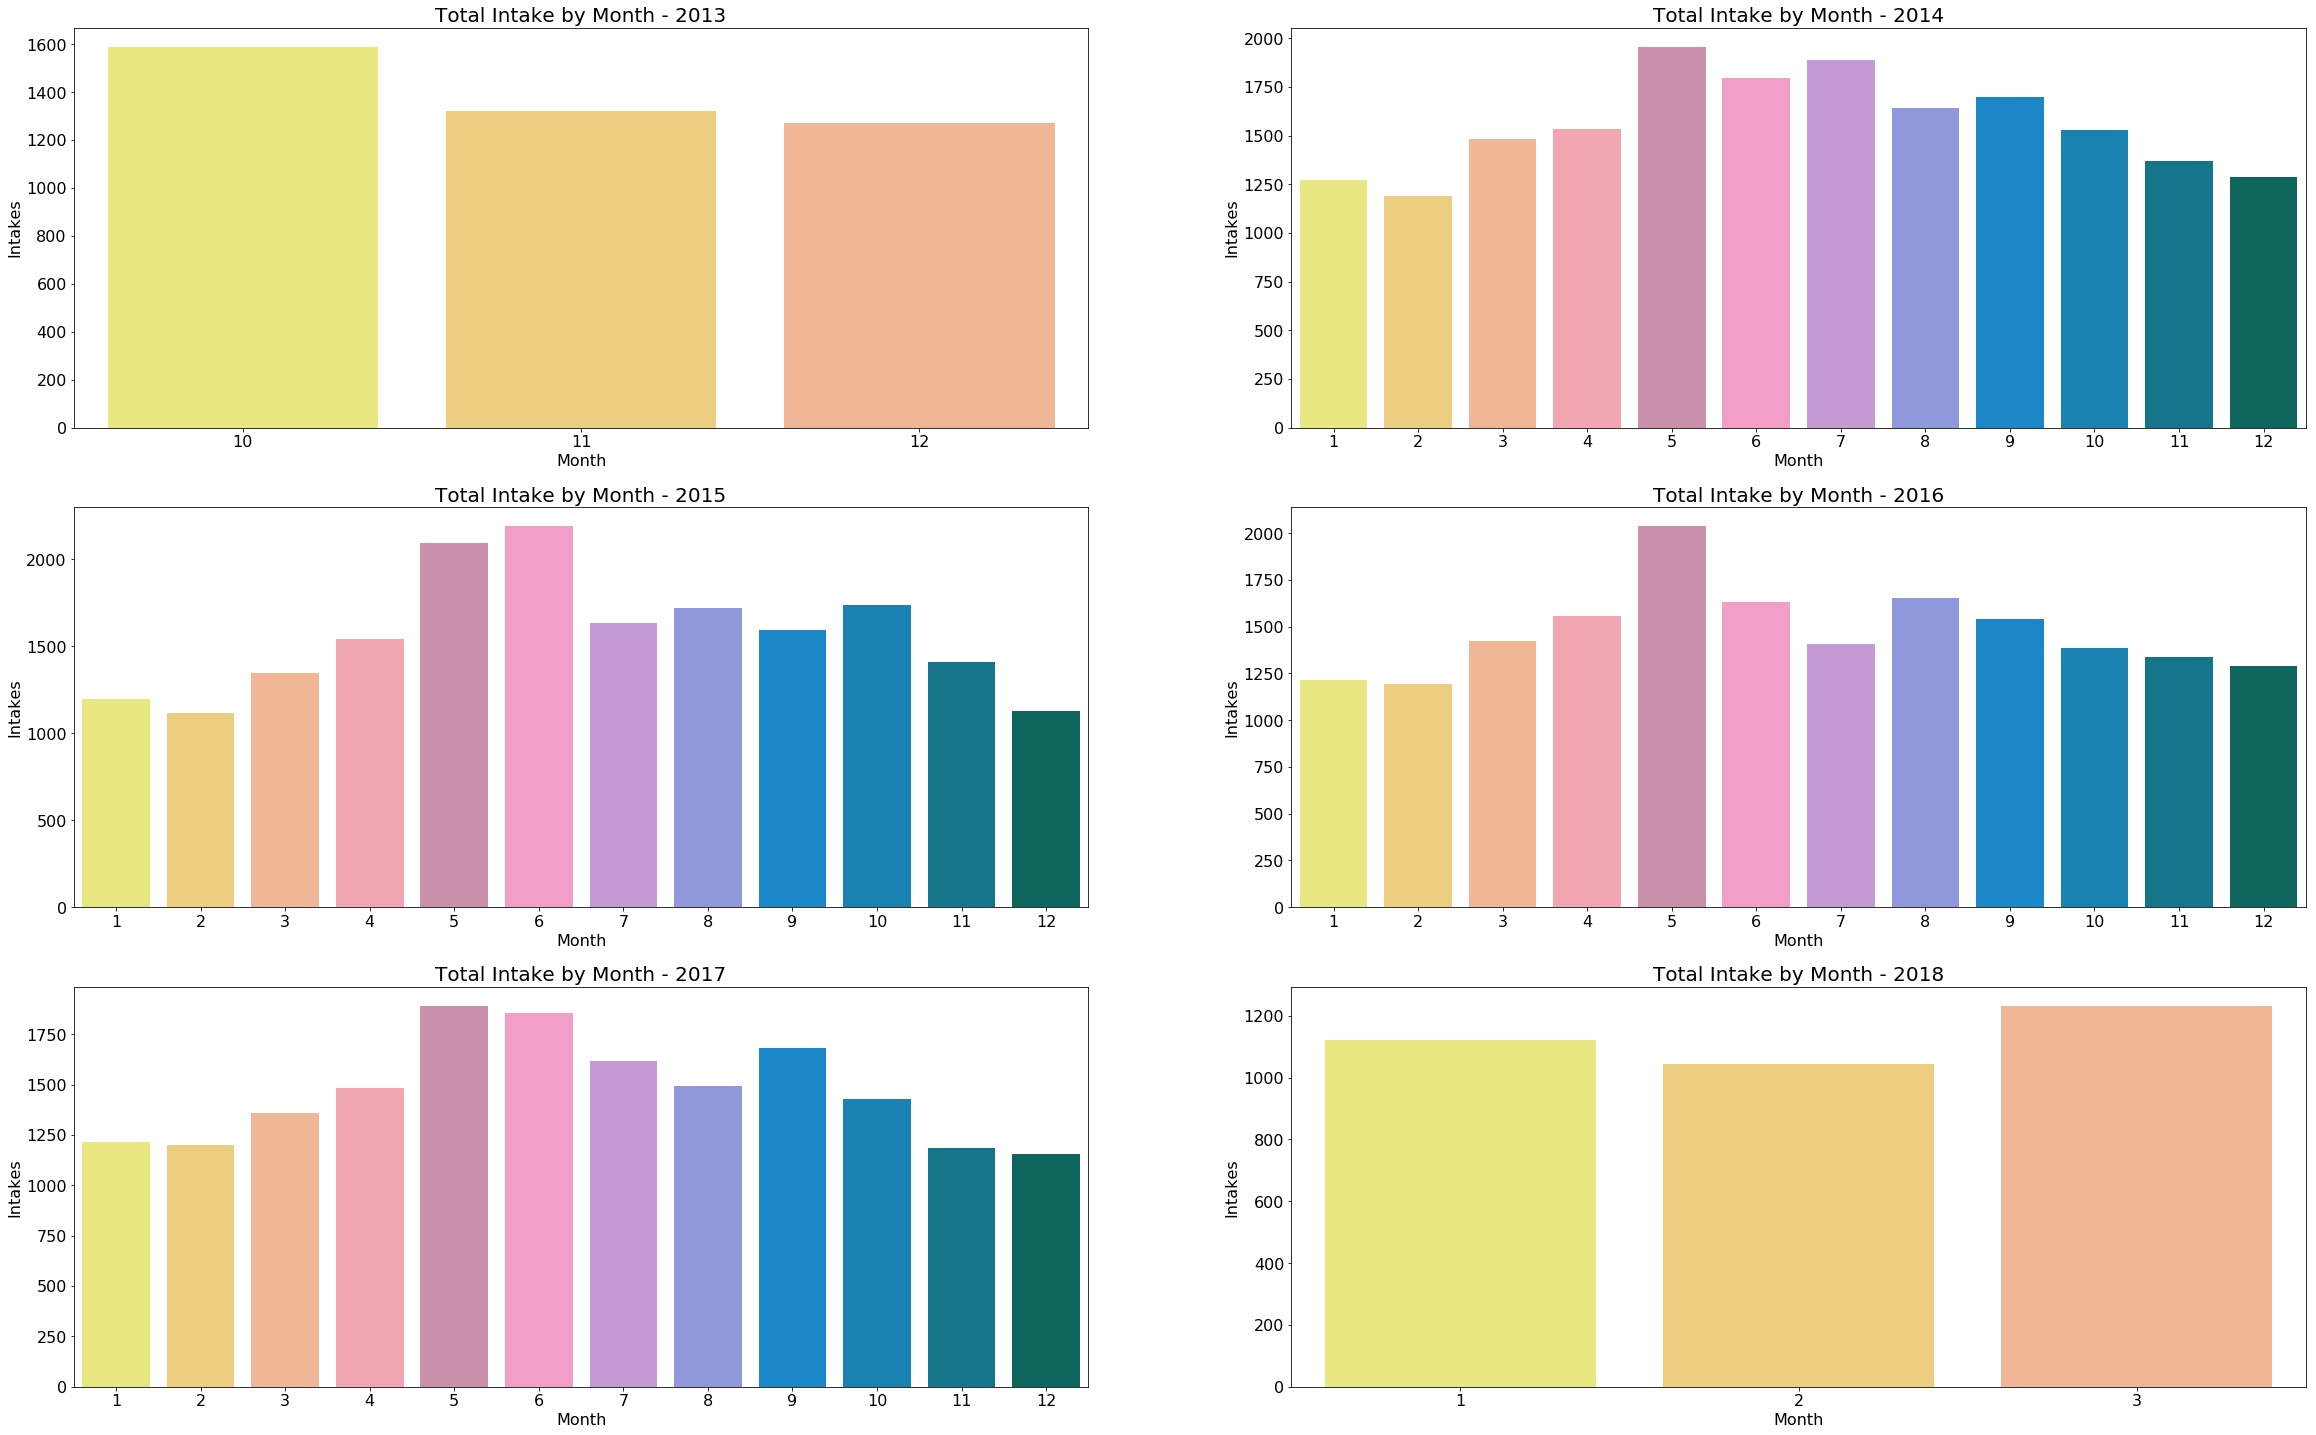

In [289]:
# Calculate the Average Intake Per Month Per Year

year_one = intakes.loc[lambda df: intakes['year'] == 2013, :]
year_two = intakes.loc[lambda df: intakes['year'] == 2014, :]
year_three = intakes.loc[lambda df: intakes['year'] == 2015, :]
year_four = intakes.loc[lambda df: intakes['year'] == 2016, :]
year_five = intakes.loc[lambda df: intakes['year'] == 2017, :]
year_six = intakes.loc[lambda df: intakes['year'] == 2018, :]

plt.figure(figsize=(40, 25))

plt.subplot(3, 2, 1)
sns.countplot(x='month', data=year_one, orient='v', palette=color_scheme)
plt.title('Total Intake by Month - 2013', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Intakes', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

plt.subplot(3, 2, 2)
sns.countplot(x='month', data=year_two, orient='v', palette=color_scheme)
plt.title('Total Intake by Month - 2014', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Intakes', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

plt.subplot(3, 2, 3)
sns.countplot(x='month', data=year_three, orient='v', palette=color_scheme)
plt.title('Total Intake by Month - 2015', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Intakes', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

plt.subplot(3, 2, 4)
sns.countplot(x='month', data=year_four, orient='v', palette=color_scheme)
plt.title('Total Intake by Month - 2016', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Intakes', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

plt.subplot(3, 2, 5)
sns.countplot(x='month', data=year_five, orient='v', palette=color_scheme)
plt.title('Total Intake by Month - 2017', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Intakes', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

plt.subplot(3, 2, 6)
sns.countplot(x='month', data=year_six, orient='v', palette=color_scheme)
plt.title('Total Intake by Month - 2018', fontsize=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Intakes', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);




Intake appears to vary a bit by year, but mostly seems to remain stable. Intake amounts peak in summer and lower in winter. This result would make sense since more people are outside with their pets in the summer or have windows or doors open, allowing them more opportunities to escape than when the weather is very cold and people might stay inside more often.

### How old are the animals when they're brought to the shelter?

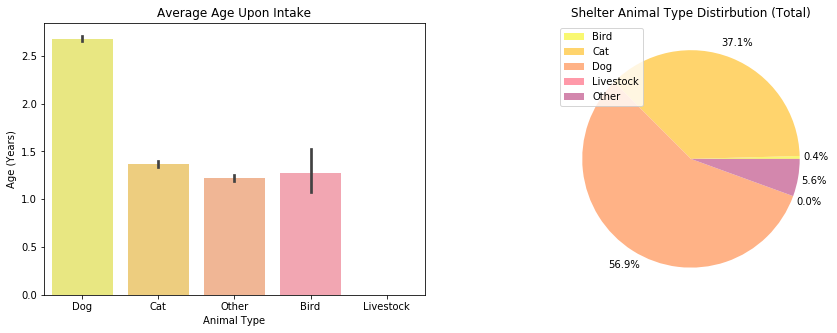

In [294]:
# Explore the different types of animals in the shelter

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='animal_type', y='age_upon_intake_(years)', data=df, palette=color_scheme)
plt.title('Average Age Upon Intake')
plt.xlabel('Animal Type')
plt.ylabel('Age (Years)')

# grouping dataset by anymal type and counting
by_at = df.groupby(['animal_type'])[['count']].sum()


plt.subplot(1, 2, 2)
names = by_at.index
size_of_groups = by_at['count']
plt.pie(size_of_groups, colors = color_scheme, 
        autopct='%1.1f%%', pctdistance=1.15)  
plt.title('Shelter Animal Type Distirbution (Total)')
plt.legend(names, loc='upper left')
plt.show()

On average, animals brought to the shelter are quite young. This information could be skewed, of course, by newborns. Many young animals like kittens and puppies are brought to the shelter after their mother has a litter, which would impact the average age. 

Using this data, however, we can conclude that the average age of an animal at the shelter is under 3 years, regardless of species. Could this be because new animal owners are more likely to accidentally let their pet escape?

### Why Do Animals Come to the Shelter? What are the Shelter Outcomes?

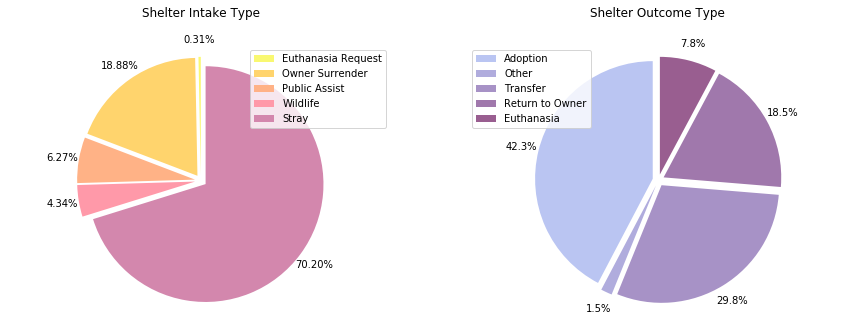

In [296]:
# pie chart of shelter outcomes
labels = [ 'Adoption', 'Other', 'Transfer', 'Return to Owner', 'Euthanasia'] 
other = (df['outcome_type'].value_counts()['Died'] 
        + df['outcome_type'].value_counts()['Rto-Adopt'] 
        + df['outcome_type'].value_counts()['Disposal']
        + df['outcome_type'].value_counts()['Missing']
        + df['outcome_type'].value_counts()['Relocate'])
outcome = [df['outcome_type'].value_counts()['Adoption'],
           other,
         df['outcome_type'].value_counts()['Transfer'],
         df['outcome_type'].value_counts()['Return to Owner'],
         df['outcome_type'].value_counts()['Euthanasia'],
         ]

plt.figure(figsize=(15,5))


#colors
colors = ['#BAC5F2','#B0ACDD','#A792C6','#A078AC', '#995E90']
explode = (0.05,0.05,0.05,0.05,0.05)

#labels=labels,
plt.subplot(1, 2, 2)
plt.pie(outcome, colors = colors, autopct='%1.1f%%', startangle=90, pctdistance=1.15, labeldistance=1.4, explode=explode)
plt.axis('equal')
plt.title('Shelter Outcome Type',y=1.08)
plt.legend(labels, loc='upper left')


labels2 = ['Euthanasia Request', 'Owner Surrender', 'Public Assist', 'Wildlife', 'Stray'] 
intake = [df['intake_type'].value_counts()['Euthanasia Request'],
         df['intake_type'].value_counts()['Owner Surrender'],
         df['intake_type'].value_counts()['Public Assist'],
         df['intake_type'].value_counts()['Wildlife'],
         df['intake_type'].value_counts()['Stray']
         ]


#explosion
explode = (0.05,0.05,0.05,0.05,0.05)
plt.subplot(1, 2, 1)
plt.pie(intake, colors = color_scheme, autopct='%1.2f%%', startangle=90, pctdistance=1.145, labeldistance=1.3, explode=explode)
plt.axis('equal')  
plt.legend(labels2, loc='upper right')
plt.title('Shelter Intake Type', y=1.08)
plt.show()

The majority of animals brought to the shelter are strays, followed by owner surrenders. Thankfully, euthanasia makes up only 7.8% of shelter outcomes, while adoption and an animal being returned to their owner make up 72.1% of outcomes.

### How Long Do Animals Spend at the Shelter Before They Reach an Outcome?

In [310]:
# Clean Datetime to date
intakes_outcomes.outcome_datetime = pd.to_datetime(intakes_outcomes.outcome_datetime)
intakes_outcomes['outcome_date'] = [x.date() for x in intakes_outcomes['outcome_datetime']]
intakes_outcomes['outcome_year'] = [x.year for x in intakes_outcomes['outcome_datetime']]

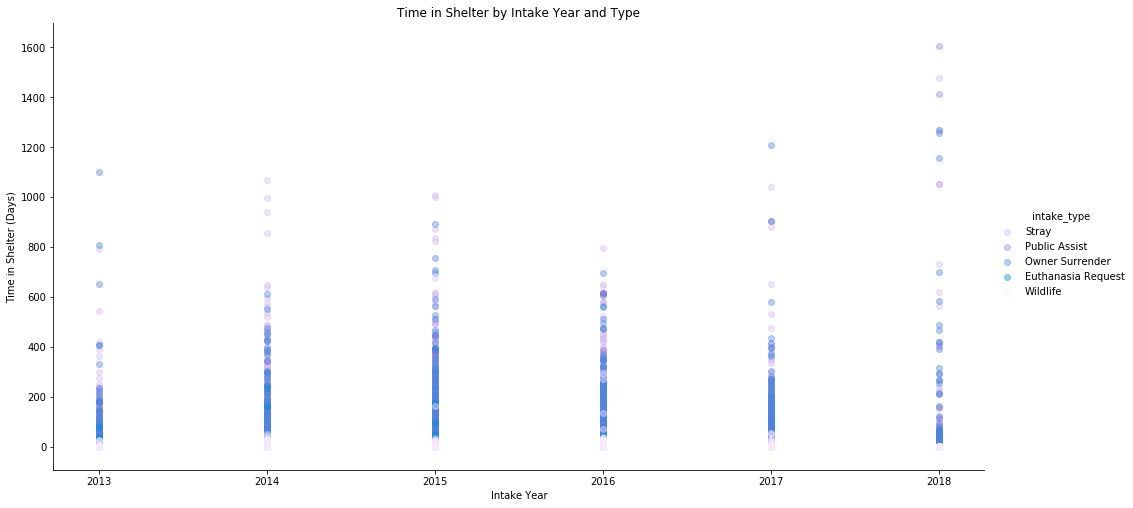

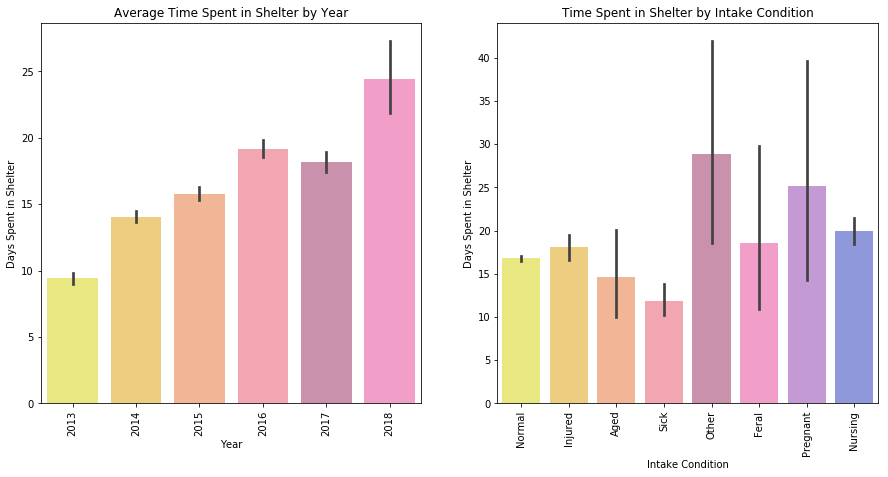

In [313]:
sns.lmplot(y='time_in_shelter_days', 
               x='intake_year',
               hue='intake_type',
               data=intakes_outcomes, # Data.
               fit_reg=False,
               height=7,
               aspect=2,
               palette = ['#D2BBF1','#A17DDB','#5184DD','#0086CC','#FAEAFF'],
               scatter_kws={'alpha':0.4})
plt.title('Time in Shelter by Intake Year and Type')
plt.xlabel('Intake Year')
plt.ylabel('Time in Shelter (Days)')

plt.figure(figsize=(15,7))

plt.subplot(1, 2, 1)
sns.barplot(x='outcome_year', y='time_in_shelter_days', data=intakes_outcomes, palette=color_scheme)
plt.title('Average Time Spent in Shelter by Year')
plt.xticks(rotation='vertical')
plt.xlabel('Year')
plt.ylabel('Days Spent in Shelter')


plt.subplot(1,2,2)
sns.barplot(x='intake_condition', y='time_in_shelter_days', data=intakes_outcomes, palette=color_scheme)
plt.title('Time Spent in Shelter by Intake Condition')
plt.xticks(rotation='vertical')
plt.xlabel('Intake Condition')
plt.ylabel('Days Spent in Shelter')
plt.show()

On average, the length of time animals are spending at the shelter has been increasing since 2013. Sick animals have the shortest length of time between income and outcome. Animals with a 'pregnant' or 'other' intake condition spend the longest length of time, on average, at the shelter.

## Part 2: Propose an Experiment 

### The Problem

Since 2013, the average length of time an animal spends at this Austin animal shelter are increasing. As well, rates that the animals are coming to the shelter have not decreased since 2013. Since shelters are overcrowded and underfunded, how can this shelter decrease the number of animals they get each month?

### Hypothesis Proposal 

The shelter should start an ad campaign for prospective pet owners about its seriousness. 

### Rollout 

Focus should be on dog and cat owners. The shelter will put on an ad campaign featuring emails, television commercials, and flyers that will be placed in the shelter along with nearby vetrinary centers and pet shops. Since 89% of animals who arrive at the shelter are either strays or owner-surrendered, the ad campaign will highlight the seriousness of adopting a pet, training them, and paying attention to where they are. Part of the campaign will also be to make new pet owners sign a form saying they are aware of the seriousness of adoption. 

### Evaluation 

The ad campaign will go on for one quarter. It will be set up as an A/B test, with the previous year's intake as the control group, and all intakes during the campaign will be counted as the test group, since not only potential new owners will be exposed to the campaign. 

Other measured variables will include any event that may significantly increase pet or animal anxiety, such as the 4th of July, when fireworks cause many pets to escape their homes in fear of the loud noises.

Key metrics are intake decrease for stray or owner-surrendered cats and dogs. If at the end of the quarter, shelter intake of this key metric decreases by one standard deviation or more, deem the ad campaign a success. If at the end of the quarter, shelter intake of this key metric does not decrease by 1 standard deviation but does decrease by more than half a standard deviation, evaluate and determine if the experiment is worth continuing. If so, continue the ad campaign for one more quarter. If after that quarter, shelter intake has not decreased by one standard deviation, terminate the ad campaign.